In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

#from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from segmentation_models import Unet
from segmentation_models.metrics import iou_score

from sklearn.metrics import confusion_matrix
import cv2 as cv


Segmentation Models: using `keras` framework.


In [ ]:
## import paths
path_train_img ='D:/matteo_gallo/25112025_2/'
path_train_mask='D:/matteo_gallo/maschera_crateri_colate/'

path_val_img ='D:/matteo_gallo/25112025_2/'
path_val_mask = 'D:/matteo_gallo/maschera_crateri_colate/'

##test Images
image_val = cv.imread(path_val_img+"25112025_ROI_ZOOMED_6.tif")

mask_val = cv.imread(path_val_mask+"maschera_crateri_colate_ROI_ZOOMED_6.tif")

img_color= np.array(image_val)
mask=np.array(mask_val)

len_training= len(os.listdir(path_train_img))
print("len_train",len_training)
len_validation= len(os.listdir(path_val_img))
print("len val",len_validation)
print("shape color img",img_color.shape)
print ("shape mask:",mask.shape)

len_train 11
len val 11
shape color img ()
shape mask: (371, 555, 3)


TypeError: Image data of dtype object cannot be converted to float

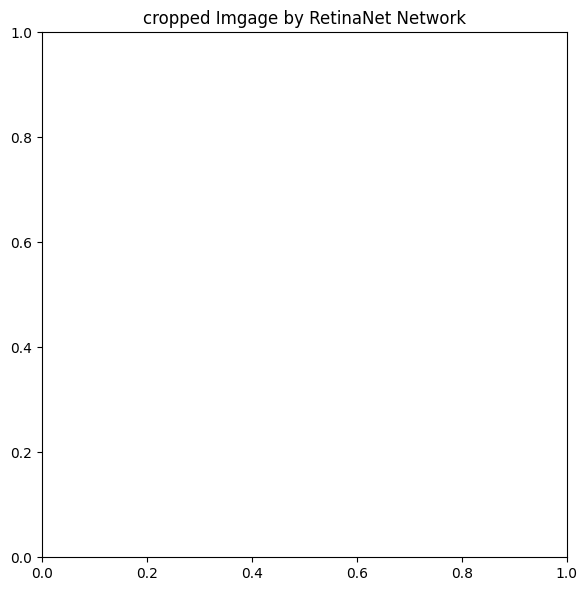

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title("cropped Imgage by RetinaNet Network")
plt.imshow(img_color)

plt.subplot(222)
plt.title("Ground thrut mask")
plt.imshow(mask)
# plt.imshow(img_color, alpha=0.3)


In [7]:
##segmentation_preprocessing
from segmentation import SegmentationGenerator

num_classes=5
batch_size=8
size= 512
print(size)

step_per_epoch_ = len_training//batch_size
step_validation= len_validation//batch_size

print(step_validation)

train_generator= SegmentationGenerator(path_train_img,
                                      path_train_mask,
                                      num_classes=num_classes,
                                      rescale=1./255,
                                      target_size=(size,size),
                                      batch_size=batch_size,
                                      shuffle=True)

512
250


In [8]:

val_generator= SegmentationGenerator(path_val_img,
                                     path_val_mask,
                                     num_classes=num_classes,
                                     rescale=1./255,
                                     target_size=(size,size),
                                     batch_size=batch_size)


In [6]:
def mapping_lava_flow_unet(pretrained_weights=None, input_size=(size,size,3)):
    
    inputs = Input(input_size)
    conv1 = Conv2D(16,3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(16,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(32,3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(32,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(64,3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(64,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(128,3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(128,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    
    conv5 = Conv2D(256,3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(256,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    pool5 = MaxPooling2D(pool_size=(2,2))(conv5)
    
    conv6 = Conv2D(512,3, activation='relu', padding='same', kernel_initializer='he_normal')(pool5)
    conv6 = Conv2D(512,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    drop6 = Dropout(0.5)(conv6)
    
    '''DECODER'''
    
    up7= Conv2DTranspose(256,3, strides=(2, 2), padding='same')(drop6)
    merge7= concatenate([conv5,up7])
    conv7= Conv2D(256,3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7= Conv2D(256,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8= Conv2DTranspose(128,3,  strides=(2, 2),padding='same',)(conv7)
    merge8= concatenate([conv4,up8],axis=3)
    conv8= Conv2D(128,3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8= Conv2D(128,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9= Conv2DTranspose(64,3,  strides=(2, 2), padding='same', )(conv8)
    merge9= concatenate([conv3,up9],axis=3)
    conv9= Conv2D(64,3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9= Conv2D(64,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    up10= Conv2DTranspose(32,3,  strides=(2, 2), padding='same')(conv9)
    merge10= concatenate([conv2,up10],axis=3)
    conv10= Conv2D(32,3, activation='relu', padding='same', kernel_initializer='he_normal')(merge10)
    conv10= Conv2D(32,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
    
    up11= Conv2DTranspose(16,3,  strides=(2, 2), padding='same')(conv10)
    merge11= concatenate([conv1,up11],axis=3)
    conv11= Conv2D(16,3, activation='relu', padding='same', kernel_initializer='he_normal')(merge11)
    conv11= Conv2D(16,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)
    conv11= Conv2D(16,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)
    
    classify= Conv2D(5,1, activation='softmax')(conv11)

    model = Model(inputs=[inputs], outputs=[classify])   
    return model

In [7]:
stromboli_unet = mapping_lava_flow_unet()
stromboli_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [8]:
stop= tf.keras.callbacks.EarlyStopping(monitor='loss',
                                       patience=10)

In [9]:
stromboli_unet.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy',iou_score])


In [10]:
hist = stromboli_unet.fit(train_generator,
                                validation_data=val_generator,
                                steps_per_epoch=step_per_epoch_,
                                validation_steps=step_validation,
                                callbacks=[stop],
                                epochs=50)

Epoch 1/50
969/969 [==============================] - 531s 537ms/step - loss: 0.0878 - accuracy: 0.9843 - iou_score: 0.5250 - val_loss: 0.0074 - val_accuracy: 0.9971 - val_iou_score: 0.7793
Epoch 2/50
969/969 [==============================] - 151s 156ms/step - loss: 0.0094 - accuracy: 0.9964 - iou_score: 0.7933 - val_loss: 0.0059 - val_accuracy: 0.9977 - val_iou_score: 0.8230
Epoch 3/50
969/969 [==============================] - 152s 157ms/step - loss: 0.0079 - accuracy: 0.9970 - iou_score: 0.8223 - val_loss: 0.0054 - val_accuracy: 0.9980 - val_iou_score: 0.8411
Epoch 4/50
969/969 [==============================] - 151s 155ms/step - loss: 0.0071 - accuracy: 0.9973 - iou_score: 0.8377 - val_loss: 0.0050 - val_accuracy: 0.9981 - val_iou_score: 0.8476
Epoch 5/50
969/969 [==============================] - 152s 157ms/step - loss: 0.0065 - accuracy: 0.9975 - iou_score: 0.8483 - val_loss: 0.0049 - val_accuracy: 0.9981 - val_iou_score: 0.8534
Epoch 6/50
969/969 [==============================

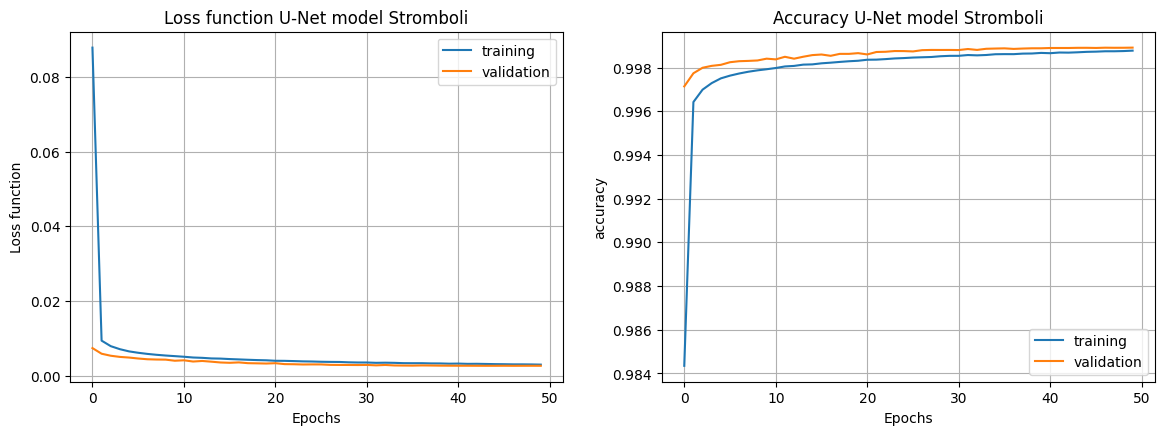

In [21]:
plt.figure(figsize=(14,10))

plt.subplot(221)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend(['training','validation'])
plt.title('Loss function U-Net model Stromboli')
plt.grid()


plt.subplot(222)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['training','validation'])
plt.title('Accuracy U-Net model Stromboli')
plt.grid()

In [9]:
from tensorflow.keras.models import save_model
stromboli_unet.save('D:/stromboli_4_colorimask.h5')

NameError: name 'stromboli_unet' is not defined

In [11]:
from keras.models import load_model
stromboli_unet= load_model('D:/stromboli_4_colorimask.h5',custom_objects= {'iou_score': iou_score})

In [12]:
val_loss, val_acc, val_iou= stromboli_unet.evaluate(val_generator,
                                                 steps=int(len(val_generator)/4))
print('extactidu es:', format(100*val_acc,'.2f'),'%')
print('IOU es', format(100*val_iou,'.2f'),'%')

62/62 [==============================] - 33s 390ms/step - loss: 0.0027 - accuracy: 0.9989 - iou_score: 0.9086
extactidu es: 99.89 %
IOU es 90.86 %


1/1 [==============================] - 0s 49ms/step
Image 1 - IoU: 0.9100
1/1 [==============================] - 0s 25ms/step
Image 2 - IoU: 0.9526
1/1 [==============================] - 0s 24ms/step
Image 3 - IoU: 0.9117
1/1 [==============================] - 0s 23ms/step
Image 4 - IoU: 0.9116
1/1 [==============================] - 0s 26ms/step
Image 5 - IoU: 0.9221
1/1 [==============================] - 0s 24ms/step
Image 6 - IoU: 0.9332
1/1 [==============================] - 0s 25ms/step
Image 7 - IoU: 0.9498
1/1 [==============================] - 0s 25ms/step
Image 8 - IoU: 0.9245
1/1 [==============================] - 0s 20ms/step
Image 9 - IoU: 0.9375
1/1 [==============================] - 0s 18ms/step
Image 10 - IoU: 0.9410
1/1 [==============================] - 0s 28ms/step
Image 11 - IoU: 0.9181
1/1 [==============================] - 0s 25ms/step
Image 12 - IoU: 0.9360
1/1 [==============================] - 0s 24ms/step
Image 13 - IoU: 0.9518
1/1 [=============================

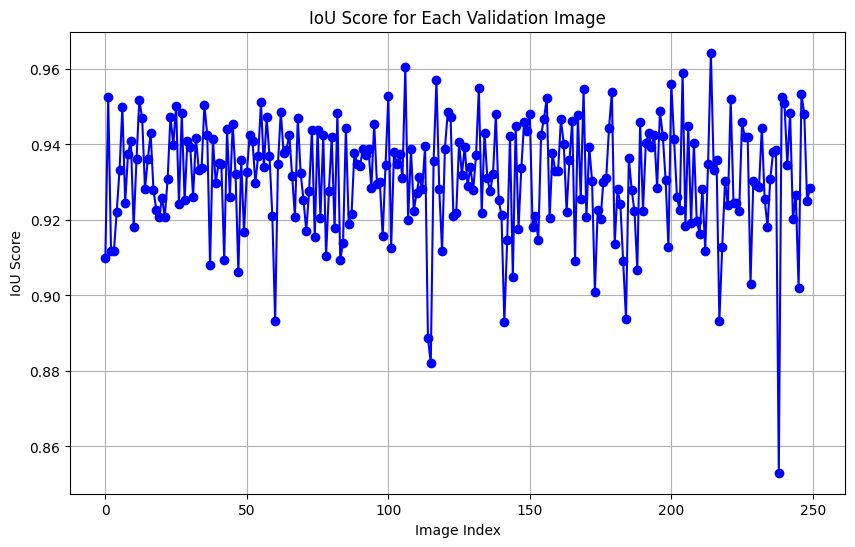

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU

# Function to calculate IoU for each image
def calculate_iou_per_image(y_true, y_pred, num_classes=5):
    y_true = np.argmax(y_true, axis=-1).flatten()
    y_pred = np.argmax(y_pred, axis=-1).flatten()

    iou_metric = MeanIoU(num_classes=num_classes)
    iou_metric.update_state(y_true, y_pred)
    return iou_metric.result().numpy()

# List to store IoU for each image
iou_scores = []

# Iterate over the validation dataset
for i, (x_val, y_true) in enumerate(val_generator):
    if i >= len(val_generator):  # Stop after going through the dataset once
        break

    # Predict the mask for the input image
    y_pred = stromboli_unet.predict(x_val)

    # Calculate IoU for the current image
    iou_score = calculate_iou_per_image(y_true, y_pred)
    iou_scores.append(iou_score)

    # Optional: Print the IoU for each image
    print(f"Image {i+1} - IoU: {iou_score:.4f}")

# Plot the IoU scores for each image
plt.figure(figsize=(10, 6))
plt.plot(iou_scores, marker='o', linestyle='-', color='b')
plt.title('IoU Score for Each Validation Image')
plt.xlabel('Image Index')
plt.ylabel('IoU Score')
plt.grid(True)
plt.show()


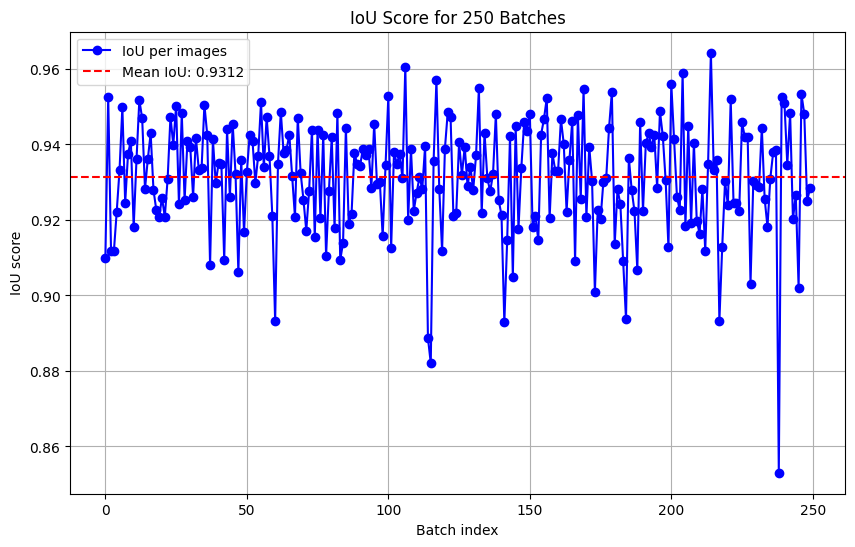

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean IoU score
mean_iou = np.mean(iou_scores)

# Plot the IoU scores for each image
plt.figure(figsize=(10, 6))
plt.plot(iou_scores, marker='o', linestyle='-', color='b', label='IoU per images')

# Plot the mean IoU as a horizontal line
plt.axhline(y=mean_iou, color='r', linestyle='--', label=f'Mean IoU: {mean_iou:.4f}')

# Add titles and labels
plt.title('IoU Score for 250 Batches')
plt.xlabel('Batch index')
plt.ylabel('IoU score')

# Add grid, legend, and display the plot
plt.grid(True)
plt.legend()
plt.show()


1/1 [==============================] - 0s 37ms/step
Image 1 - IoU: 0.9100
1/1 [==============================] - 0s 29ms/step
Image 2 - IoU: 0.9526
1/1 [==============================] - 0s 30ms/step
Image 3 - IoU: 0.9117
1/1 [==============================] - 0s 26ms/step
Image 4 - IoU: 0.9116
1/1 [==============================] - 0s 24ms/step
Image 5 - IoU: 0.9221
1/1 [==============================] - 0s 24ms/step
Image 6 - IoU: 0.9332
1/1 [==============================] - 0s 31ms/step
Image 7 - IoU: 0.9498
1/1 [==============================] - 0s 26ms/step
Image 8 - IoU: 0.9245
1/1 [==============================] - 0s 30ms/step
Image 9 - IoU: 0.9375
1/1 [==============================] - 0s 20ms/step
Image 10 - IoU: 0.9410
1/1 [==============================] - 0s 21ms/step
Image 11 - IoU: 0.9181
1/1 [==============================] - 0s 22ms/step
Image 12 - IoU: 0.9360
1/1 [==============================] - 0s 28ms/step
Image 13 - IoU: 0.9518
1/1 [=============================

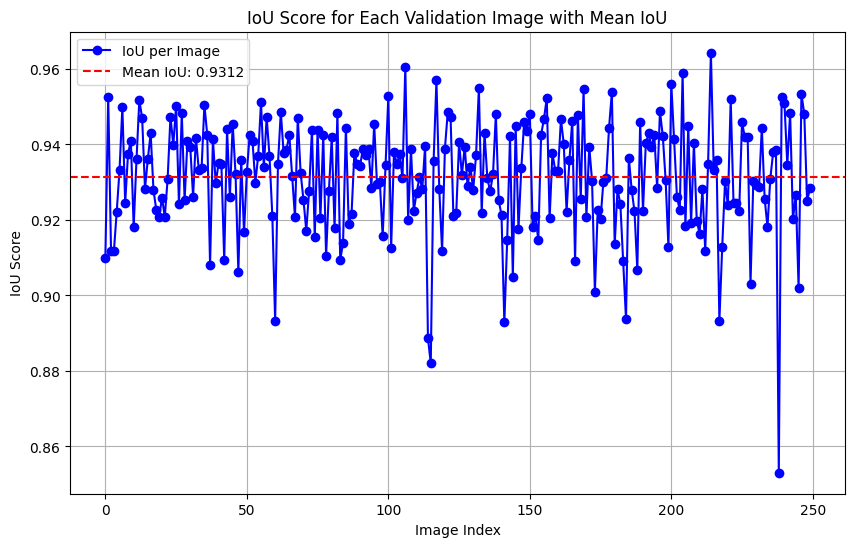

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU

# Function to calculate IoU for each image
def calculate_iou_per_image(y_true, y_pred, num_classes=5):
    y_true = np.argmax(y_true, axis=-1).flatten()
    y_pred = np.argmax(y_pred, axis=-1).flatten()

    iou_metric = MeanIoU(num_classes=num_classes)
    iou_metric.update_state(y_true, y_pred)
    return iou_metric.result().numpy()

# List to store IoU for each image
iou_scores = []

# Iterate over the validation dataset without limiting steps
for i, (x_val, y_true) in enumerate(val_generator):
    # Predict the mask for the input image
    y_pred = stromboli_unet.predict(x_val)

    # Calculate IoU for the current image
    iou_score = calculate_iou_per_image(y_true, y_pred)
    iou_scores.append(iou_score)

    # Optional: Print the IoU for each image
    print(f"Image {i+1} - IoU: {iou_score:.4f}")

    if i >= len(val_generator) - 1:  # Stop after processing all images
        break

# Calculate the mean IoU score
mean_iou = np.mean(iou_scores)

# Plot the IoU scores for each image
plt.figure(figsize=(10, 6))
plt.plot(iou_scores, marker='o', linestyle='-', color='b', label='IoU per Image')

# Plot the mean IoU as a horizontal line
plt.axhline(y=mean_iou, color='r', linestyle='--', label=f'Mean IoU: {mean_iou:.4f}')

# Add titles and labels
plt.title('Mean IoU Score for 250 Batches')
plt.xlabel('Image Index')
plt.ylabel('IoU Score')

# Add grid, legend, and display the plot
plt.grid(True)
plt.legend()
plt.show()


In [14]:
## Extraemos las imagenes  y las mascaras de validacion

x_val=[]
y_val=[]

for i in range(len(val_generator)):
    y_val.extend(val_generator[i])
    x_val.extend(val_generator[i])

: 

In [15]:
# realizamos predicciones con el metodo predict_generator

#prob_val = unet_model_lava_flow.predict(val_generator)
prob_val = stromboli_unet.predict(val_generator)

250/250 [==============================] - 71s 283ms/step


In [14]:
model= load_model('D:/stromboli_4_colorimask.h5',custom_objects= {'iou_score': iou_score})
test_path="C:/Users/fr4nc/OneDrive/Escritorio/test_spt/test_spt/test/images/images/"
test_path_mask="C:/Users/fr4nc/OneDrive/Escritorio/test_spt/test_spt/test/mask/mask/"

In [23]:
from segmentation import SegmentationGenerator

num_classes=5
batch_size=8
size= 512
print(size)


test_generator= SegmentationGenerator(test_path,
                                     test_path_mask,
                                     num_classes=num_classes,
                                     rescale=1./255,
                                     target_size=(size,size))

512


In [25]:
## Extraemos las imagenes  y las mascaras de validacion

x_test=[]
y_test=[]

for i in range(len(test_generator)):
    y_test.extend(test_generator[i])
    x_test.extend(test_generator[i])

In [28]:
results = model.predict(test_generator)

6/6 [==============================] - 0s 39ms/step


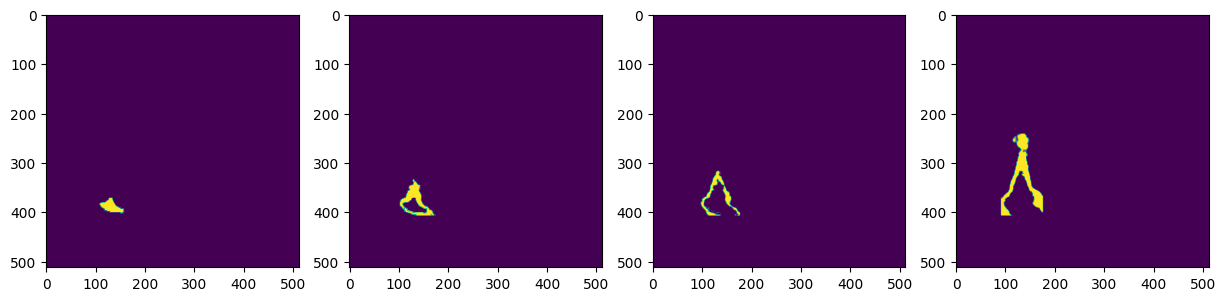

In [66]:

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow((results[1][:,:,1]))
plt.subplot(142)
plt.imshow((results[1][:,:,2]))
plt.subplot(143)
plt.imshow(results[1][:,:,3])
plt.subplot(144)
plt.imshow(results[1][:,:,4])





6/6 [==============================] - 0s 68ms/step


TypeError: Invalid shape (1, 512, 5) for image data

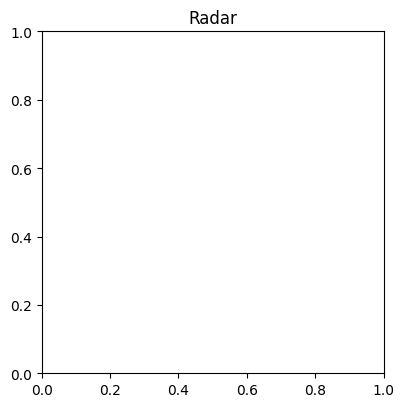

In [54]:
import random
test_img_number = random.randint(0, len(x_test))
test_img = x_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_generator))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(15, 15))
plt.subplot(231)
plt.title('Radar')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Ground Truth Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction Image (UNET)')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [13]:
# ===== IoU por clase (por imagen) y CSV =====
import numpy as np
import pandas as pd
from tensorflow.keras.metrics import MeanIoU

# (Opcional) nombres de clases para el CSV
CLASS_NAMES = {i: f"class_{i}" for i in range(num_classes)}

def _confmat_np(y_true, y_pred, C):
    mask = (y_true >= 0) & (y_true < C)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    cm = np.bincount(C * y_true + y_pred, minlength=C*C).reshape(C, C)
    return cm

def _iou_from_cm(cm):
    tp = np.diag(cm).astype(np.float64)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    denom = tp + fp + fn
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.where(denom > 0, tp / denom, np.nan)
    return iou  # shape (C,)

def _per_image_iou(y_true_oh, y_pred_oh, C):
    # asegúrate de tener forma [H, W, C]
    if y_true_oh.ndim == 4: y_true_oh = y_true_oh[0]
    if y_pred_oh.ndim == 4: y_pred_oh = y_pred_oh[0]
    y_true = np.argmax(y_true_oh, axis=-1).astype(np.int32).ravel()
    y_pred = np.argmax(y_pred_oh, axis=-1).astype(np.int32).ravel()

    # intenta usar MeanIoU para obtener la matriz de confusión (si está disponible)
    try:
        m = MeanIoU(num_classes=C)
        m.update_state(y_true, y_pred)
        cm = m.total_cm.numpy() if hasattr(m, "total_cm") else np.array(m.get_weights()).reshape(C, C)
    except Exception:
        cm = _confmat_np(y_true, y_pred, C)

    iou_c = _iou_from_cm(cm)
    miou = np.nanmean(iou_c)
    return iou_c, miou

rows = []
img_idx = 0

for b, (x_val, y_true) in enumerate(val_generator):
    if b >= len(val_generator):  # recorrer solo una vez
        break
    y_pred = stromboli_unet.predict(x_val, verbose=0)

    B = y_true.shape[0]
    for i in range(B):
        iou_c, miou = _per_image_iou(y_true[i], y_pred[i], num_classes)
        for c_id, v in enumerate(iou_c):
            rows.append({
                "image_index": img_idx,
                "class_id": c_id,
                "class_name": CLASS_NAMES.get(c_id, f"class_{c_id}"),
                "iou_class": float(v) if np.isfinite(v) else np.nan,
                "miou_image": float(miou) if np.isfinite(miou) else np.nan,
            })
        img_idx += 1

# CSV detallado por imagen y clase
df_per_image = pd.DataFrame(rows)
df_per_image.to_csv("D:/iou_per_image_per_class.csv", index=False)

# Resumen: promedio de IoU por clase en todo el val set
df_summary = (
    df_per_image.groupby(["class_id", "class_name"], dropna=False)["iou_class"]
    .mean().reset_index().rename(columns={"iou_class": "mean_iou_over_dataset"})
    .sort_values("class_id")
)
df_summary.to_csv("D:/iou_summary_per_class.csv", index=False)

print("Guardado:")
print(" - D:/iou_per_image_per_class.csv")
print(" - D:/iou_summary_per_class.csv")
print(df_summary.to_string(index=False))


Guardado:
 - D:/iou_per_image_per_class.csv
 - D:/iou_summary_per_class.csv
 class_id class_name  mean_iou_over_dataset
        0    class_0               0.999655
        1    class_1               0.929930
        2    class_2               0.841935
        3    class_3               0.733602
        4    class_4               0.871072
